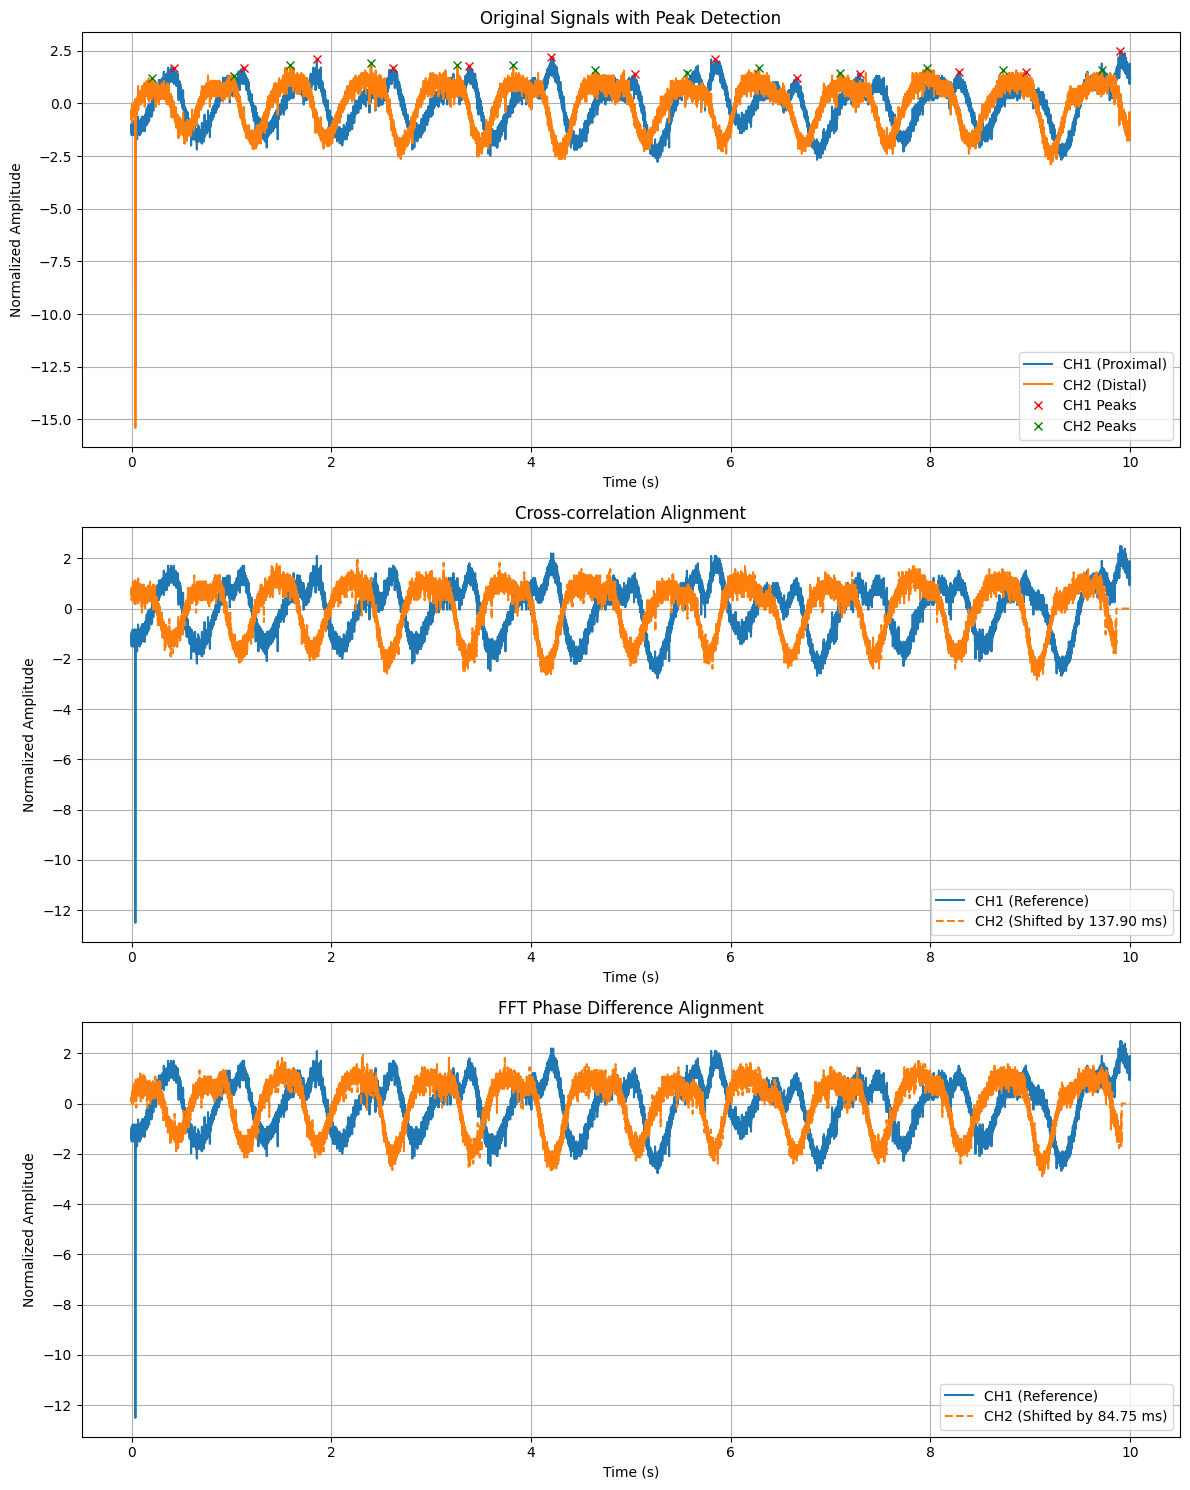

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def analyze_time_delay(df, sample_duration=10):
    # Extract time and signals
    time = df['Time'].values
    ch1_signal = df['CH1'].values
    ch2_signal = df['CH2'].values
    
    # Calculate sampling frequency
    sampling_freq = 1 / np.mean(np.diff(time))
    
    # Select sample duration
    sample_points = int(sample_duration * sampling_freq)
    ch1_sample = ch1_signal[:sample_points]
    ch2_sample = ch2_signal[:sample_points]
    time_sample = time[:sample_points]

    # Normalize signals
    ch1_norm = (ch1_sample - np.mean(ch1_sample)) / np.std(ch1_sample)
    ch2_norm = (ch2_sample - np.mean(ch2_sample)) / np.std(ch2_sample)

    # Method 1: Cross-correlation
    correlation = signal.correlate(ch1_norm, ch2_norm, mode='full', method='fft')
    lags = signal.correlation_lags(len(ch1_norm), len(ch2_norm), mode='full')
    corr_delay = lags[np.argmax(correlation)] / sampling_freq

    # Method 2: FFT Phase Difference
    f1 = np.fft.fft(ch1_norm)
    f2 = np.fft.fft(ch2_norm)
    freq = np.fft.fftfreq(len(time_sample), d=1/sampling_freq)
    phase_diff = np.angle(f2) - np.angle(f1)
    # Use frequencies between 0.5 and 4 Hz (typical heart rate range)
    mask = (np.abs(freq) >= 0.5) & (np.abs(freq) <= 4)
    valid_phase = phase_diff[mask]
    valid_freq = freq[mask]
    # Calculate delay from phase slope
    fft_delay = -np.mean(valid_phase[valid_freq > 0] / (2 * np.pi * valid_freq[valid_freq > 0]))

    # Find peaks for visualization
    ch1_peaks, _ = find_peaks(ch1_norm, height=0.5, distance=int(sampling_freq*0.5))
    ch2_peaks, _ = find_peaks(ch2_norm, height=0.5, distance=int(sampling_freq*0.5))

    # Create visualization
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

    # Plot 1: Original signals with detected peaks
    ax1.plot(time_sample, ch1_norm, label='CH1 (Proximal)')
    ax1.plot(time_sample, ch2_norm, label='CH2 (Distal)')
    ax1.plot(time_sample[ch1_peaks], ch1_norm[ch1_peaks], "rx", label='CH1 Peaks')
    ax1.plot(time_sample[ch2_peaks], ch2_norm[ch2_peaks], "gx", label='CH2 Peaks')
    ax1.set_title('Original Signals with Peak Detection')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Normalized Amplitude')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Signals aligned using cross-correlation
    shift_samples_corr = int(corr_delay * sampling_freq)
    ch2_shifted_corr = np.zeros_like(ch2_norm)
    if shift_samples_corr > 0:
        ch2_shifted_corr[:-shift_samples_corr] = ch2_norm[shift_samples_corr:]
    else:
        ch2_shifted_corr[-shift_samples_corr:] = ch2_norm[:shift_samples_corr]
    
    ax2.plot(time_sample, ch1_norm, label='CH1 (Reference)')
    ax2.plot(time_sample, ch2_shifted_corr, '--', label=f'CH2 (Shifted by {corr_delay*1000:.2f} ms)')
    ax2.set_title('Cross-correlation Alignment')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Normalized Amplitude')
    ax2.legend()
    ax2.grid(True)

    # Plot 3: Signals aligned using FFT phase difference
    shift_samples_fft = int(fft_delay * sampling_freq)
    ch2_shifted_fft = np.zeros_like(ch2_norm)
    if shift_samples_fft > 0:
        ch2_shifted_fft[:-shift_samples_fft] = ch2_norm[shift_samples_fft:]
    else:
        ch2_shifted_fft[-shift_samples_fft:] = ch2_norm[:shift_samples_fft]
    
    ax3.plot(time_sample, ch1_norm, label='CH1 (Reference)')
    ax3.plot(time_sample, ch2_shifted_fft, '--', label=f'CH2 (Shifted by {fft_delay*1000:.2f} ms)')
    ax3.set_title('FFT Phase Difference Alignment')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Normalized Amplitude')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

    return corr_delay, fft_delay
file_path = 'output_with_time125_77_89.csv'
df = pd.read_csv(file_path)

# Example usage:
time_delay_corr, time_delay_fft = analyze_time_delay(df)
# print(f"Cross-correlation delay: {time_delay_corr*1000:.2f} ms")
# print(f"FFT phase delay: {time_delay_fft*1000:.2f} ms")

Sampling frequency: 9999.90 Hz
Cross-correlation delay: 137.90 ms
FFT phase delay: 84.75 ms
Average Heart Rate: 78.00 BPM


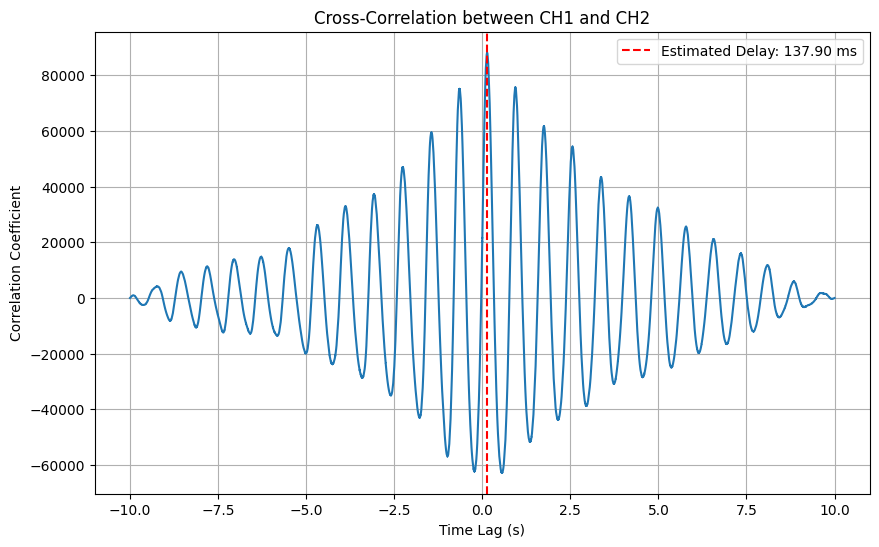

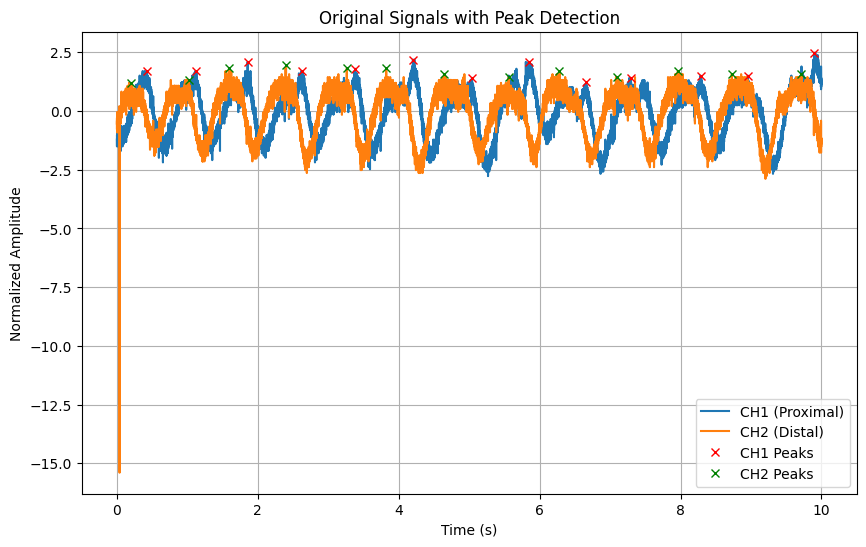

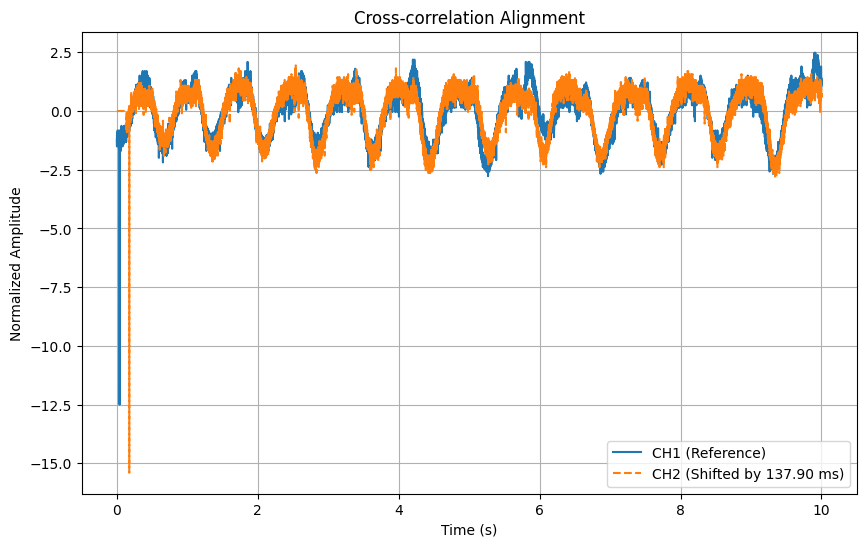

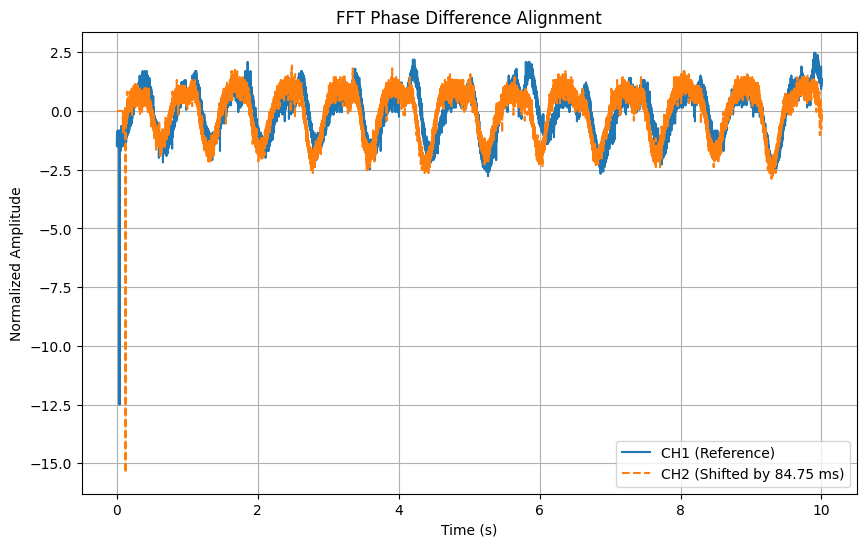

Systolic: 129 mmHg
Diastolic: 75 mmHg
Average Heart Rate: 78 BPM


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import find_peaks

def analyze_time_delays(df, sample_duration=10):
    """
    Analyze time delays using both cross-correlation and FFT methods,
    with comprehensive visualization including correlation plot
    """
    # Extract time and signals
    time = df['Time'].values
    ch1_signal = df['CH1'].values
    ch2_signal = df['CH2'].values
    
    # Calculate sampling frequency
    sampling_freq = 1 / np.mean(np.diff(time))
    print(f"Sampling frequency: {sampling_freq:.2f} Hz")

    # Select sample duration
    sample_points = int(sample_duration * sampling_freq)
    ch1_sample = ch1_signal[:sample_points]
    ch2_sample = ch2_signal[:sample_points]
    time_sample = time[:sample_points]

    # Normalize signals
    ch1_norm = (ch1_sample - np.mean(ch1_sample)) / np.std(ch1_sample)
    ch2_norm = (ch2_sample - np.mean(ch2_sample)) / np.std(ch2_sample)

    # Method 1: Cross-correlation
    correlation = signal.correlate(ch1_norm, ch2_norm, mode='full', method='fft')
    lags = signal.correlation_lags(len(ch1_norm), len(ch2_norm), mode='full')
    max_corr_index = np.argmax(correlation)
    corr_delay = lags[max_corr_index] / sampling_freq

    # Method 2: FFT Phase Difference
    f1 = np.fft.fft(ch1_norm)
    f2 = np.fft.fft(ch2_norm)
    freq = np.fft.fftfreq(len(time_sample), d=1/sampling_freq)
    phase_diff = np.angle(f2) - np.angle(f1)
    # Use frequencies between 0.5 and 4 Hz (typical heart rate range)
    mask = (np.abs(freq) >= 0.5) & (np.abs(freq) <= 4)
    valid_phase = phase_diff[mask]
    valid_freq = freq[mask]
    fft_delay = -np.mean(valid_phase[valid_freq > 0] / (2 * np.pi * valid_freq[valid_freq > 0]))

    # Find peaks for visualization
    ch1_peaks, _ = find_peaks(ch1_norm, height=0.5, distance=int(sampling_freq*0.5))
    ch2_peaks, _ = find_peaks(ch2_norm, height=0.5, distance=int(sampling_freq*0.5))

    print(f"Cross-correlation delay: {corr_delay*1000:.2f} ms")
    print(f"FFT phase delay: {fft_delay*1000:.2f} ms")
    hr_ch1 = (len(ch1_peaks) / sample_duration) * 60
    hr_ch2 = (len(ch2_peaks) / sample_duration) * 60
    avg_heart_rate = (hr_ch1 + hr_ch2) / 2
    print(f"Average Heart Rate: {avg_heart_rate:.2f} BPM")
    
    # Figure 1: Cross-correlation
    plt.figure(figsize=(10, 6))
    plt.plot(lags / sampling_freq, correlation)
    plt.title('Cross-Correlation between CH1 and CH2')
    plt.xlabel('Time Lag (s)')
    plt.ylabel('Correlation Coefficient')
    plt.axvline(x=corr_delay, color='r', linestyle='--', 
                label=f'Estimated Delay: {corr_delay*1000:.2f} ms')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure 2: Original signals with detected peaks
    plt.figure(figsize=(10, 6))
    plt.plot(time_sample, ch1_norm, label='CH1 (Proximal)')
    plt.plot(time_sample, ch2_norm, label='CH2 (Distal)')
    plt.plot(time_sample[ch1_peaks], ch1_norm[ch1_peaks], "rx", label='CH1 Peaks')
    plt.plot(time_sample[ch2_peaks], ch2_norm[ch2_peaks], "gx", label='CH2 Peaks')
    plt.title('Original Signals with Peak Detection')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure 3: Signals aligned using cross-correlation
    shift_samples_corr = int(corr_delay * sampling_freq)
    ch2_shifted_corr = np.zeros_like(ch2_norm)
    if shift_samples_corr < 0:
        ch2_shifted_corr[:shift_samples_corr] = ch2_norm[-shift_samples_corr:]
    else:
        ch2_shifted_corr[shift_samples_corr:] = ch2_norm[:-shift_samples_corr]
    
    plt.figure(figsize=(10, 6))
    plt.plot(time_sample, ch1_norm, label='CH1 (Reference)')
    plt.plot(time_sample, ch2_shifted_corr, '--', 
             label=f'CH2 (Shifted by {corr_delay*1000:.2f} ms)')
    plt.title('Cross-correlation Alignment')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure 4: Signals aligned using FFT phase difference
    shift_samples_fft = int(fft_delay * sampling_freq)
    ch2_shifted_fft = np.zeros_like(ch2_norm)
    if shift_samples_fft < 0:
        ch2_shifted_fft[:shift_samples_fft] = ch2_norm[-shift_samples_fft:]
    else:
        ch2_shifted_fft[shift_samples_fft:] = ch2_norm[:-shift_samples_fft]
    
    plt.figure(figsize=(10, 6))
    plt.plot(time_sample, ch1_norm, label='CH1 (Reference)')
    plt.plot(time_sample, ch2_shifted_fft, '--', 
             label=f'CH2 (Shifted by {fft_delay*1000:.2f} ms)')
    plt.title('FFT Phase Difference Alignment')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

    # print(f"Cross-correlation delay: {corr_delay*1000:.2f} ms")
    # print(f"FFT phase delay: {fft_delay*1000:.2f} ms")
    # print(f"Average Heart Rate: {avg_heart_rate:.2f} BPM")

    # Calculate heart rate from peaks
    # hr_ch1 = (len(ch1_peaks) / sample_duration) * 60
    # hr_ch2 = (len(ch2_peaks) / sample_duration) * 60
    # avg_heart_rate = (hr_ch1 + hr_ch2) / 2
    # print(f"Average Heart Rate: {avg_heart_rate:.2f} BPM")

    return corr_delay, fft_delay, avg_heart_rate

file_path = 'output_with_time125_77_89.csv'
df = pd.read_csv(file_path)

# Example usage:
time_delay_corr, time_delay_fft, avg_heart_rate = analyze_time_delays(df)

time_delay = abs(time_delay_corr * 1000)
a = -0.3152
b = 172.85
c = -0.0741
d = 85.444
systolic = time_delay * a + b
diastolic = time_delay * c + d

print(f"Systolic: {int(systolic)} mmHg")
print(f"Diastolic: {int(diastolic)} mmHg")
print(f"Heart Rate: {int(avg_heart_rate)} BPM")